In [1]:
import pycbc
from pycbc.waveform import get_td_waveform
from pycbc.psd import welch, interpolate
import h5py 
import urllib
import pylab
import numpy as np
import timeit
import os
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz, spectrogram

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1
/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [3]:
# Parameter for generating EOB waveform, I use the function, get_td_waveform, which from PyCBC
f_low = 20
sample_rate = 8192
m1_ini = 5.0
m2_ini = 5.0
m1 = m1_ini
m2 = m2_ini
m1_max = 20.0
m2_max = 20.0
delta_m = 0.5 # step of mass choosing.
data_length = 8192 # How long is the data, here I keep 8192 point, which is 1 sec.
pure_noise_number = 8000 # number of pure noise data
noise_to_signal = 1.9 #snr倒數
#snr = 0.36
dt = float(1) / sample_rate
fband = [43.0, 800.0] # band-pass, for whitening.
T = data_length / sample_rate

# Saveing direction.
approximation = 'EOBNRv2'
apporxi = 'GW_training_data_EOBNRv2_whitened_template'
folder_name = 'data_1.9'

nitv = 16.0
novl = 8.0
NITV = int(sample_rate/nitv)
NOVL = int(NITV*(novl-1)/novl)
window = np.blackman(NITV)
spec_cmap='ocean'

# Whitening function

In [3]:
def whiten(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    #freqs1 = np.linspace(0,4096.,Nt/2+1)

    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(np.abs(interp_psd(freqs))) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    
    bb, ab = butter(4, [fband[0]*2./sample_rate, fband[1]*2./sample_rate], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(sample_rate/2))
    strain_whitenbp = filtfilt(bb, ab, white_ht) / normalization
    return strain_whitenbp

In [4]:
### function to whiten data
def whiten2(strain, interp_psd, dt):
    Nt = len(strain)
    freqs = np.fft.rfftfreq(Nt, dt)
    freqs1 = np.linspace(0,2048.,Nt/2+1)

    # whitening: transform to freq domain, divide by asd, then transform back, 
    # taking care to get normalization right.
    hf = np.fft.rfft(strain)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

    # now whiten the data from H1 and L1, and the template (use H1 PSD):
    strain_H1_whiten = whiten(strain_H1,psd_H1,dt)
    strain_L1_whiten = whiten(strain_L1,psd_L1,dt)
    
    # We need to suppress the high frequency noise (no signal!) with some bandpassing:
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band') #butter、filtfilt 為 scipy.signal 的函式
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_H1_whitenbp = filtfilt(bb, ab, strain_H1_whiten) / normalization
    strain_L1_whitenbp = filtfilt(bb, ab, strain_L1_whiten) / normalization

# White noise

In [4]:
def wgn(multiple,signal,snrdb): #white gaussian noise ,noies長度為signal的multiple倍
    snr = snrdb*1 #snrdb無單位
    #snr = 10**(snrdb/10.) #snrdb單位為分貝(10倍以10為底對數)
    l = len(signal)
    signalpower = np.sum(signal*signal)/l #資料點振幅各自平方再相加，除以資料長度 = 平均功率
    noisepower = signalpower/snr
    return np.random.normal(loc=0.0, scale=1.0, size=multiple*l) * np.sqrt(noisepower) #mean=0,standard deviation=1

In [6]:
def wgn2(multiple,signal,snr):
    l = len(signal)
    signalpower = np.max(signal)
    noisepower = signalpower/snr
    return np.random.normal(loc=0.0, scale=1.0, size=multiple*l) * noisepower #mean=0,standard deviation=1

# Power Spectrum Density for whitening

Text(0.5,1,'PSD used for whitening (interp)')

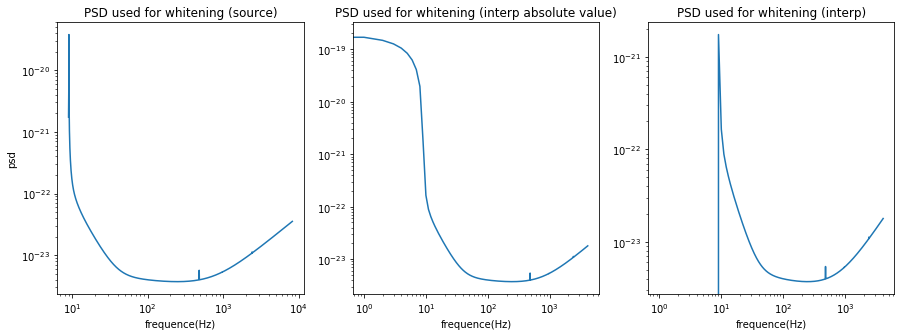

In [4]:
Pxx = pylab.loadtxt('/Users/tang-ching-yao/Documents/deep_learning/GW DL model/high.txt')
freqs = Pxx[:,0]
Pxx = Pxx[:,1]
psd_smooth = interp1d(freqs, Pxx, fill_value="extrapolate")

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.loglog(freqs, Pxx)
plt.xlabel('frequence(Hz)')
plt.ylabel('psd')
plt.title('PSD used for whitening (source)')
#plt.xlim(0,2000)

plt.subplot(132)
plt.loglog(np.fft.rfftfreq(8192, dt), np.abs(psd_smooth(np.fft.rfftfreq(8192, dt))))
plt.xlabel('frequence(Hz)')
#plt.ylabel('psd')
plt.title('PSD used for whitening (interp absolute value)')

plt.subplot(133)
plt.loglog(np.fft.rfftfreq(8192, dt), psd_smooth(np.fft.rfftfreq(8192, dt)))
plt.xlabel('frequence(Hz)')
#plt.ylabel('psd')
plt.title('PSD used for whitening (interp)')

Text(0.5,1,'PSD used for whitening (interp)')

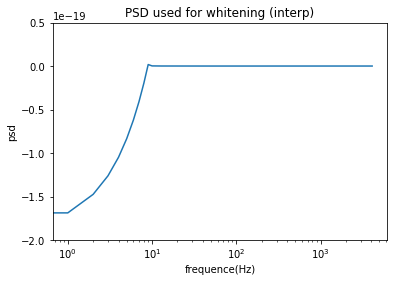

In [7]:
plt.semilogx(np.fft.rfftfreq(8192, dt), psd_smooth(np.fft.rfftfreq(8192, dt)))
plt.ylim(-2e-19,5e-20)
plt.xlabel('frequence(Hz)')
plt.ylabel('psd')
plt.title('PSD used for whitening (interp)')

In [107]:
#f
print 'lenth f =',sample_rate/nitv/2+1
#t
print 'lenth t =',(nitv*T-1)*novl+1
print 'total',(sample_rate/nitv/2+1)*((nitv*T-1)*novl+1)

lenth f = 257.0
lenth t = 121.0
total 31097.0


# Show the waveform and the spectrogram

In [16]:
def wavepicture(mass1, mass2, fl, pr, opp=None):
    tlist = np.linspace(0, T, data_length)
    hp, hc = get_td_waveform(approximant=approximation,
                                     mass1=mass1,
                                     mass2=mass2,
                                     f_lower=fl,
                                     delta_t=1.0/sample_rate)
    del hc
    hp = np.copy(hp) #get_td_waveform得到的是pycbc 的 timeseries object，故用copy將其轉為array
    whp=whiten(hp, psd_smooth, dt)
    lhp = len(hp)
    print 'len hp =',lhp
    
    start_index = lhp - data_length
    end_index = lhp
    hp = hp[start_index:end_index]
    whp = whp[start_index:end_index]
    mhp = np.max(hp)
    mwhp = np.max(whp)
    ratio = mhp/mwhp
    

    plt.figure(figsize=(10,25))
    ###pure GW
    ax1 = plt.subplot2grid((7, 1), (0, 0))
    plt.plot(tlist, whp*ratio, "k", label='whitening GW rescale')
    plt.plot(tlist, hp, "y--", label='original GW')
    #plt.xlim(0.015625,0.984375)
    plt.legend(loc='upper left')
    plt.xlabel('time(s)')
    plt.ylabel('strain')
    plt.xlim(0,1)
    
    ###GW with whiten
    ax2 = plt.subplot2grid((7, 1), (1, 0))
    plt.plot(tlist, whp, label='whitening GW')
    plt.plot(tlist, hp, "y--", label='original GW')
    #plt.xlim(0.015625,0.984375)
    plt.legend(loc='upper left')
    plt.xlabel('time(s)')
    plt.ylabel('strain')
    plt.xlim(0,1)
    
    
    idxmaxf = int(sample_rate/nitv/2+1 - 1)
    idxmaxt = int((nitv*T-1)*novl+1 - 1)
    
    ###whiten GW spectrogram
    f, t, Sxx = spectrogram(x=whp, nfft=NITV, fs=sample_rate, window=window, noverlap=NOVL,detrend=False)
    ax3 = plt.subplot2grid((7, 1), (2, 0),rowspan=2)
    plt.imshow(Sxx[:int(idxmaxf/4),:],cmap='binary',origin='lower')
    #print(np.max(Sxx))
    #plt.yticks([0,idxmaxf/4,idxmaxf/2,idxmaxf*3/4,idxmaxf] , [0,1024,2048,3072,4096])
    plt.yticks([0,idxmaxf/32,idxmaxf/16,idxmaxf*3/32,idxmaxf/8,idxmaxf*3/16,idxmaxf/4],[0,128,256,384,512,768,1024])
    plt.xticks([0,idxmaxt/4,idxmaxt/2,idxmaxt*3/4,idxmaxt] , [0,0.25,0.5,0.75,1])
    plt.xlabel('time(s)')
    plt.ylabel('frequency(Hz)')
    plt.title('spectrogram of pure whitened GW signal')

    
    
    print 'lenf =',len(f)
    print 'lent =',len(t)

    whp_max = max(whp)
    if opp == None :
        noise = np.random.normal(0, 1./pr * whp_max, data_length)
    else:
        noise = wgn2(1, whp, pr)
    whp_noise = whp + noise
    signalpower = np.sum(whp*whp)/len(whp)
    noisepower = np.sum(noise*noise)/len(noise)
    print 'avg SNR =',signalpower/noisepower
    print 'peak Amplitude ratio =',whp_max/np.sqrt(noisepower)
    print 'peak SNR =',whp_max*whp_max/(noisepower)
    
    
    ###whiten GW with noise
    ax4 = plt.subplot2grid((7, 1), (4, 0))
    plt.plot(tlist, whp_noise,label='with noise')
    plt.plot(tlist, whp,"y",label='whitened GW')
    #plt.xlim(0.015625,0.984375)
    plt.legend(loc='upper left')
    plt.xlabel('time(s)')
    plt.ylabel('strain')
    plt.xlim(0,1)
    plt.xticks([0,0.25,0.5,0.75,1])
    plt.title('whitened GW signal with noise')

    
    #whiten GW with noise spectrogram
    f, t, Sxx = spectrogram(whp_noise, nfft=NITV, fs=sample_rate, window=window, noverlap=NOVL,detrend=False)
    ax5 = plt.subplot2grid((7, 1), (5, 0),rowspan=2)
    plt.imshow(Sxx[:int(idxmaxf/4),:],cmap='binary',origin='lower')
    #print(np.max(Sxx))
    #plt.yticks([0,idxmaxf/4,idxmaxf/2,idxmaxf*3/4,idxmaxf] , [0,1024,2048,3072,4096])
    plt.yticks([0,idxmaxf/32,idxmaxf/16,idxmaxf*3/32,idxmaxf/8,idxmaxf*3/16,idxmaxf/4],[0,128,256,384,512,768,1024])
    #plt.xticks([0,248,496,744,992] , [0.015625,0.234375,0.484375,0.71875,0.984375])
    plt.xticks([0,idxmaxt/4,idxmaxt/2,idxmaxt*3/4,idxmaxt] , [0,0.25,0.5,0.75,1])
    plt.xlabel('time(s)')
    plt.ylabel('frequency(Hz)')
    plt.title('spectrogram of whitened GW signal with noise')

    
    plt.show()

len hp = 12097
lenf = 257
lent = 121
avg SNR = 0.006493526752954831
peak Amplitude ratio = 0.800644780065696
peak SNR = 0.6410320638464466


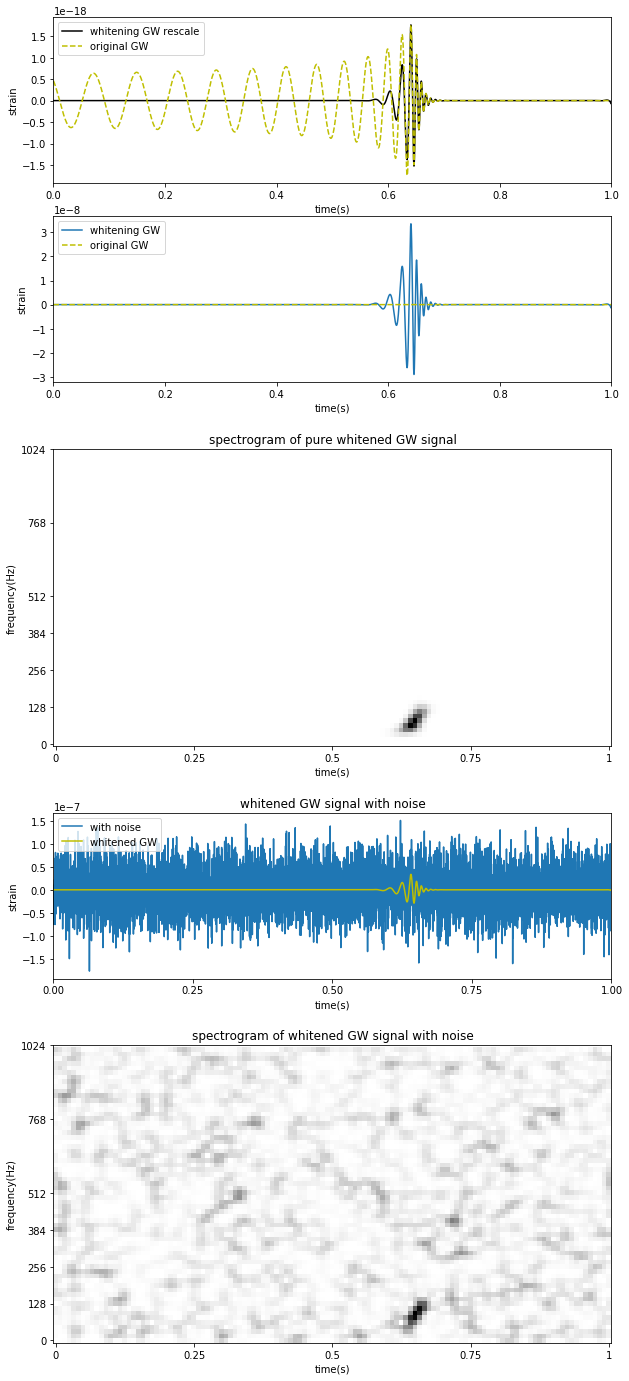

In [17]:
wavepicture(75, 75, 10, 0.8)

len hp = 13537
lenf = 257
lent = 121
avg SNR = 0.03665051687391255
peak Amplitude ratio = 0.7901205669326873
peak SNR = 0.6242905102900311


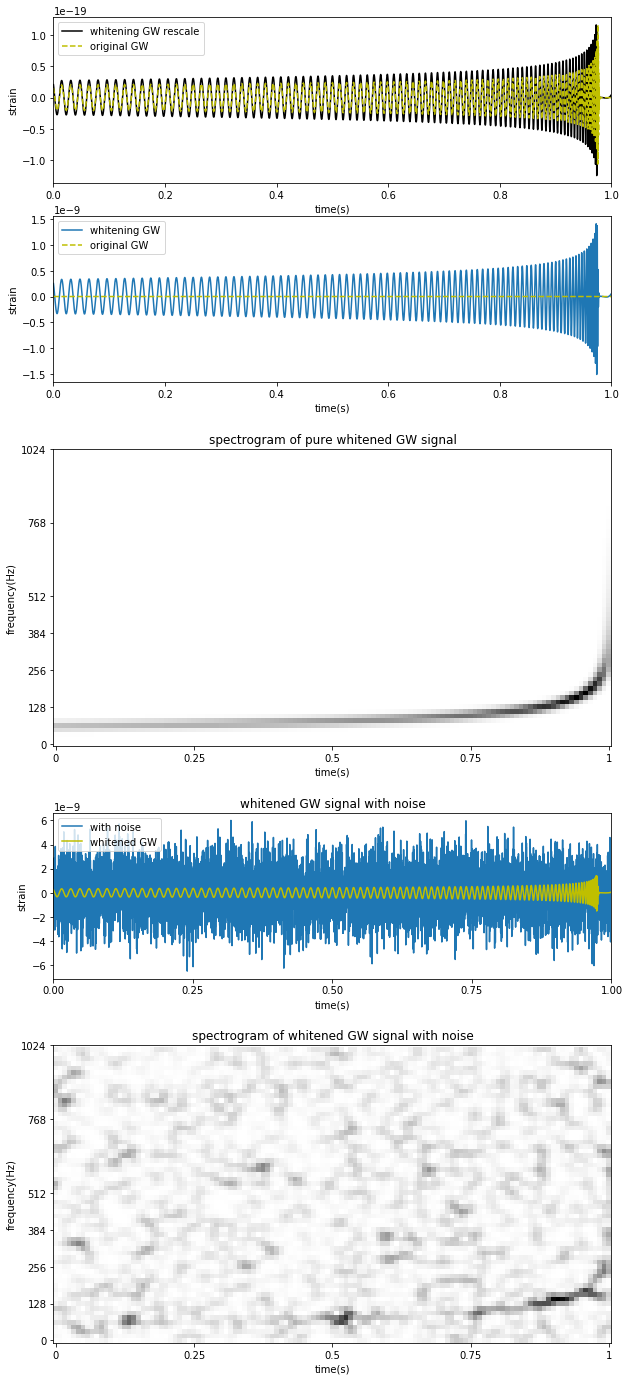

In [18]:
wavepicture(5, 5, 50, 0.8)

len hp = 10978
lenf = 257
lent = 121
avg SNR = 0.016562871358448285
peak Amplitude ratio = 0.7991228916049417
peak SNR = 0.6385973958870433


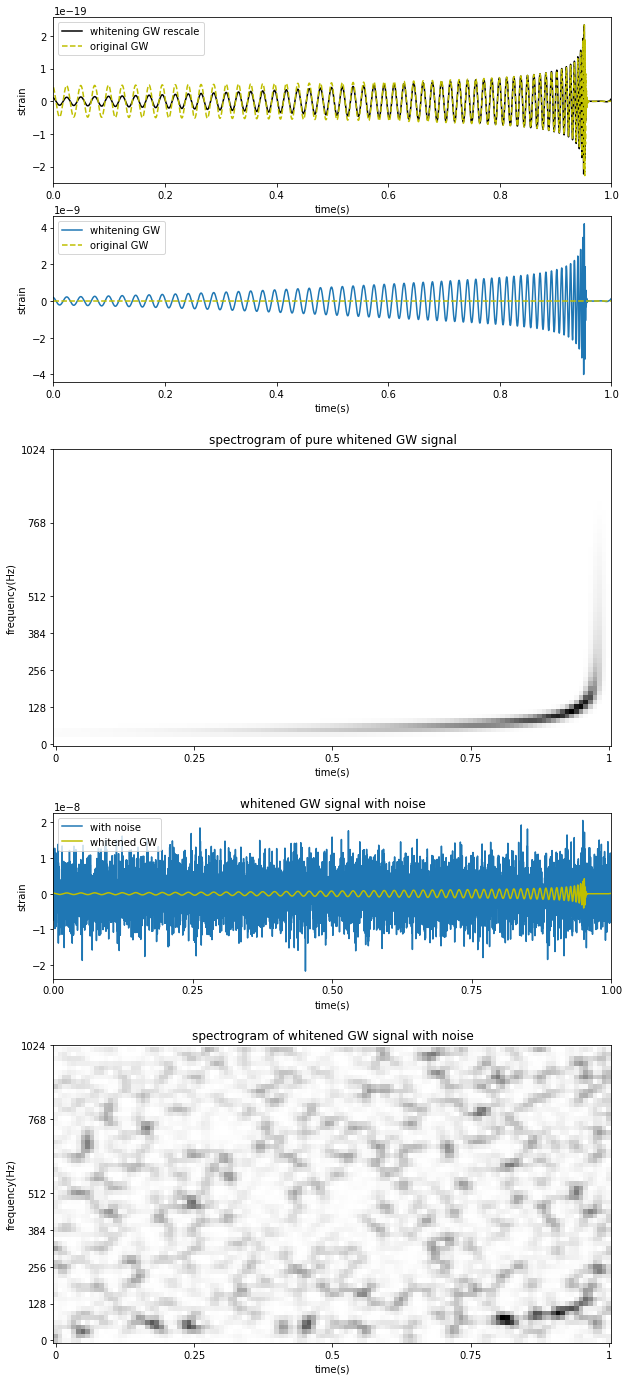

In [19]:
wavepicture(10, 10, 35, 0.8)

len hp = 10836
lenf = 257
lent = 121
avg SNR = 0.011655485265894957
peak Amplitude ratio = 0.8040876751933974
peak SNR = 0.6465569893979225


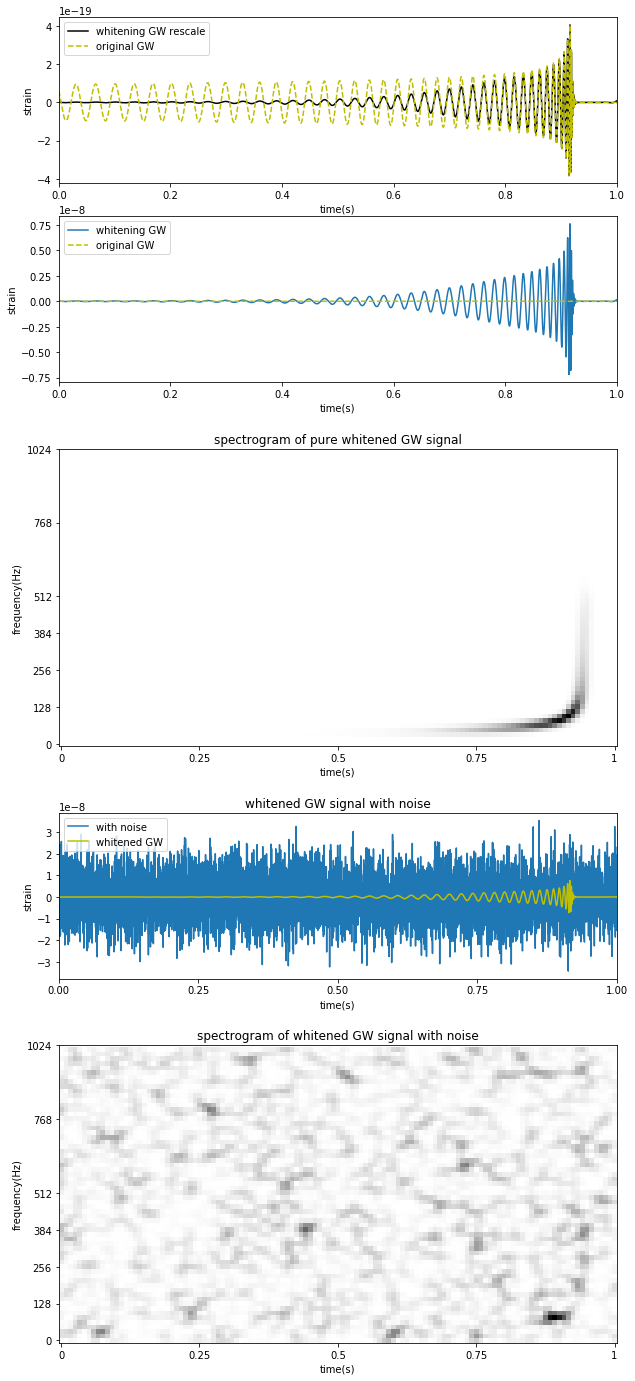

In [20]:
wavepicture(20, 15, 25, 0.8)

len hp = 15421
lenf = 257
lent = 121
avg SNR = 0.010852730541801463
peak Amplitude ratio = 0.7987111914953381
peak SNR = 0.6379395674199027


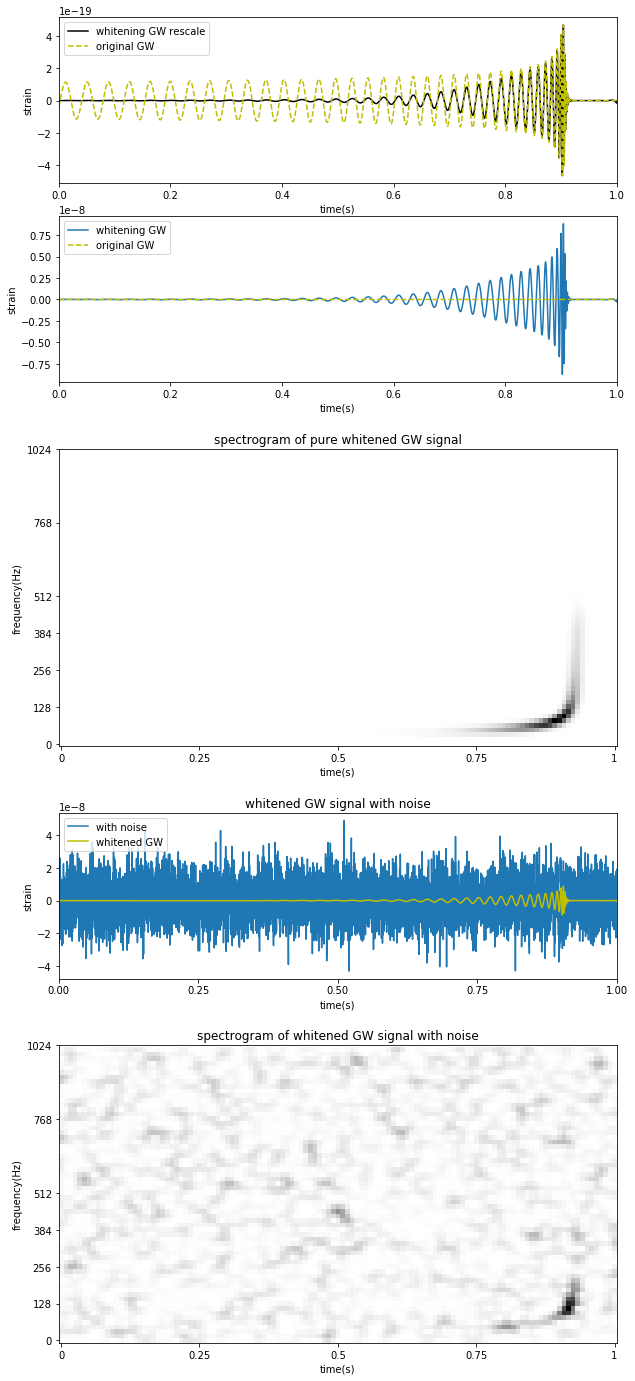

In [21]:
wavepicture(20, 20, 20, 0.8)

len hp = 21506
lenf = 257
lent = 121
avg SNR = 0.007801877687931267
peak Amplitude ratio = 0.7909149196237797
peak SNR = 0.6255464100834899


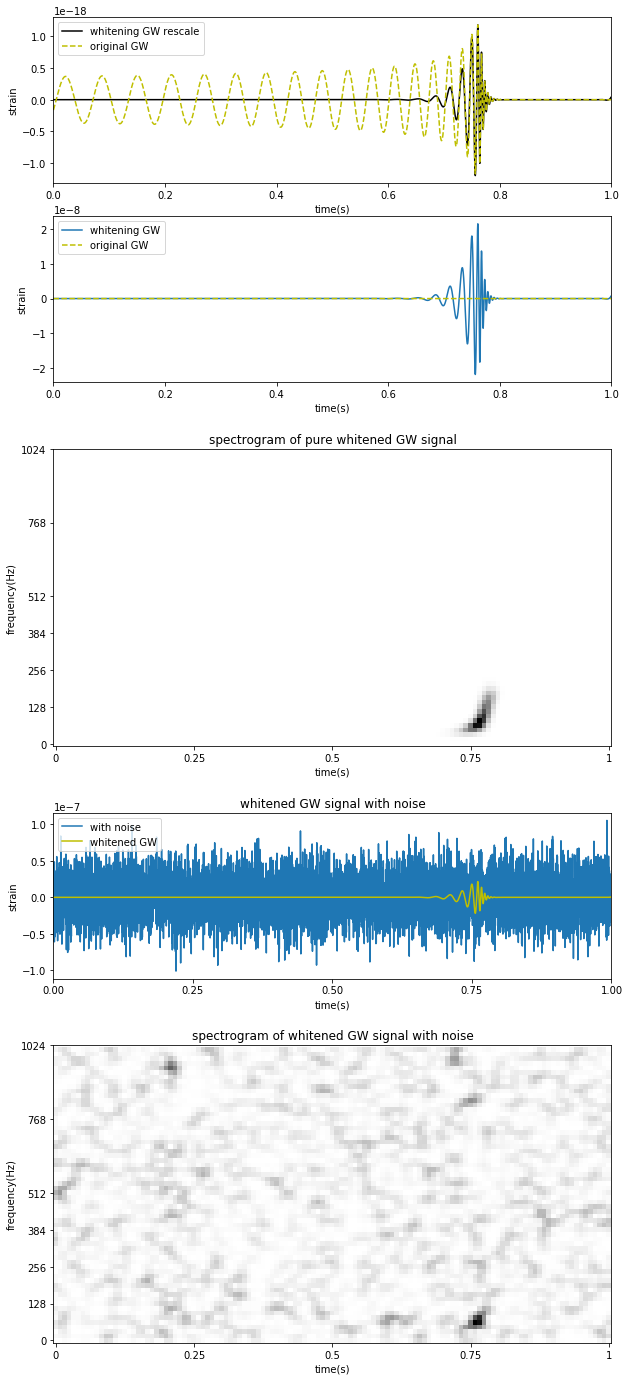

In [22]:
wavepicture(50, 50, 10, 0.8)

len hp = 12097
lenf = 257
lent = 121
avg SNR = 0.00652043108406671
peak Amplitude ratio = 0.8023017029462355
peak SNR = 0.6436880225504295


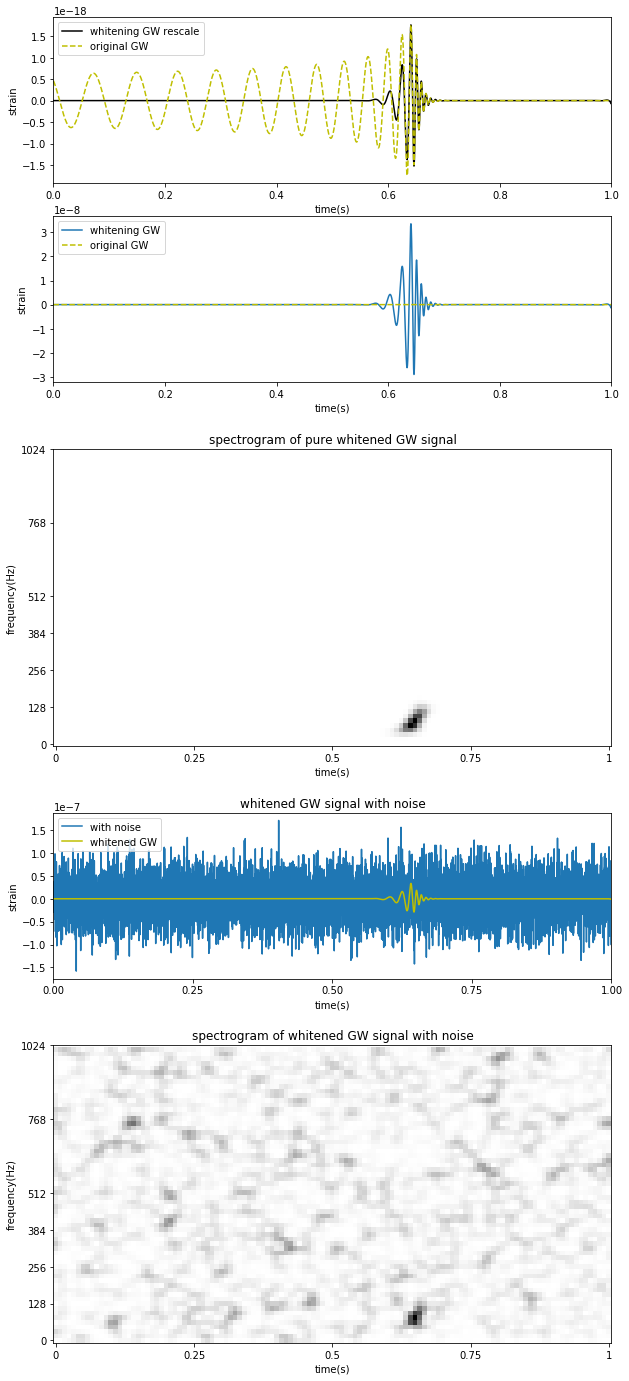

In [23]:
wavepicture(75, 75, 10, 0.8)

len hp = 23411
lenf = 257
lent = 121
avg SNR = 0.0067737120306439165
peak Amplitude ratio = 0.4969361575302278
peak SNR = 0.24694554466090735


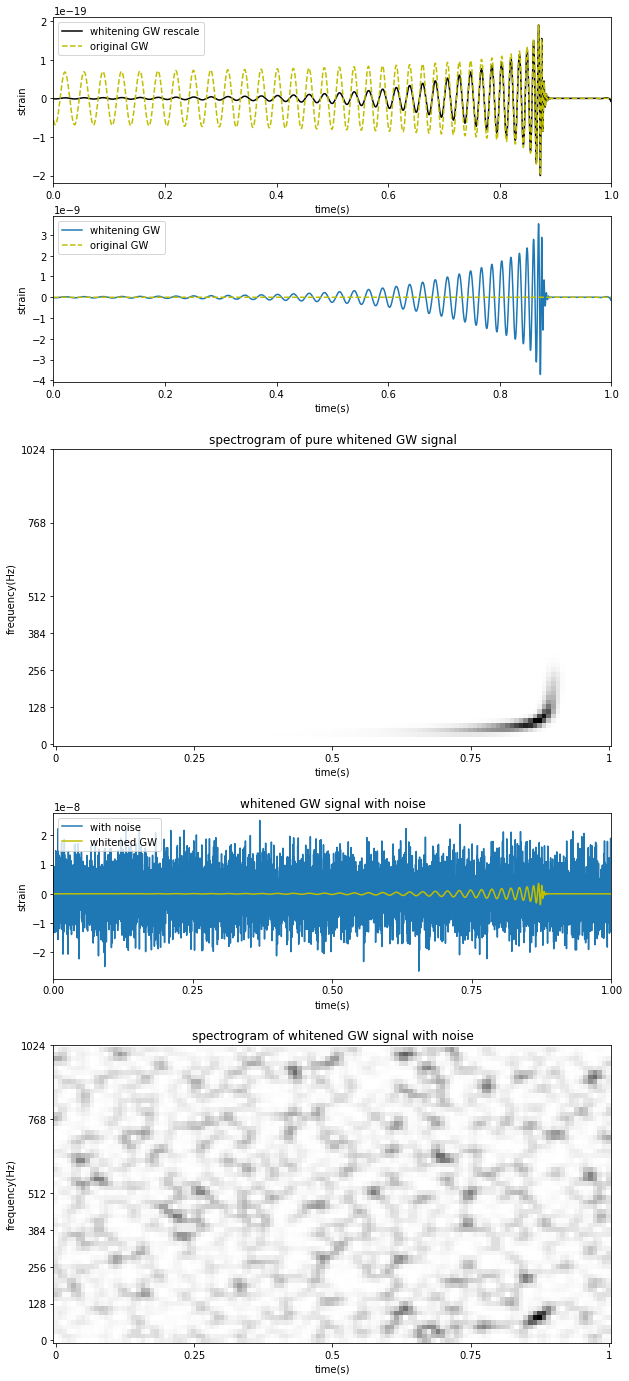

In [24]:
wavepicture(5, 50, 20, 0.5)

In [26]:
def wavepicture2(mass1, mass2, fl, pr, opp=None):
    tlist = np.linspace(0, T, data_length)
    hp, hc = get_td_waveform(approximant=approximation,
                                     mass1=mass1,
                                     mass2=mass2,
                                     f_lower=fl,
                                     delta_t=1.0/sample_rate)
    del hc
    hp = np.copy(hp) #get_td_waveform得到的是pycbc 的 timeseries object，故用copy將其轉為array
    whp=whiten(hp, psd_smooth, dt)
    lhp = len(hp)
    print 'len hp =',lhp
    
    start_index = lhp - data_length
    end_index = lhp
    hp = hp[start_index:end_index]
    whp = whp[start_index:end_index]
    mhp = np.max(hp)
    mwhp = np.max(whp)
    ratio = mhp/mwhp
    
    idxmaxf = int(sample_rate/nitv/2+1 - 1)
    idxmaxt = int((nitv*T-1)*novl+1 - 1)
    
    plt.figure(figsize=(15,10))
    ###whiten GW spectrogram
    f, t, Sxx = spectrogram(x=whp, nfft=NITV, fs=sample_rate, window=window, noverlap=NOVL,detrend=False)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    plt.imshow(Sxx[:int(idxmaxf/4),:],cmap='binary',origin='lower')
    #print(np.max(Sxx))
    #plt.yticks([0,idxmaxf/4,idxmaxf/2,idxmaxf*3/4,idxmaxf] , [0,1024,2048,3072,4096])
    plt.yticks([0,idxmaxf/32,idxmaxf/16,idxmaxf*3/32,idxmaxf/8,idxmaxf*3/16,idxmaxf/4],[0,128,256,384,512,768,1024])
    plt.xticks([0,idxmaxt/4,idxmaxt/2,idxmaxt*3/4,idxmaxt] , [0,0.25,0.5,0.75,1])
    plt.xlabel('time(s)')
    plt.ylabel('frequency(Hz)')
    plt.title('spectrogram of pure whitened GW signal')
    ax = plt.gca()
    ax.yaxis.set_ticks_position('right')
    

    whp_max = max(whp)
    if opp == None :
        noise = np.random.normal(0, 1./pr * whp_max, data_length)
    else:
        noise = wgn2(1, whp, pr)
    whp_noise = whp + noise
    signalpower = np.sum(whp*whp)/len(whp)
    noisepower = np.sum(noise*noise)/len(noise)
    print 'avg SNR =',signalpower/noisepower
    print 'peak Amplitude ratio =',whp_max/np.sqrt(noisepower)
    print 'peak SNR =',whp_max*whp_max/(noisepower)
    
    
    ###whiten GW with noise
    ax2 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    plt.plot(tlist, whp_noise,label='with noise')
    plt.plot(tlist, whp,"y",label='whitened GW')
    #plt.xlim(0.015625,0.984375)
    plt.legend(loc='upper left')
    plt.xlabel('time(s)')
    plt.ylabel('strain')
    plt.xlim(0-0.01,1+0.01)
    plt.xticks([0,0.25,0.5,0.75,1])
    plt.title('whitened GW signal with noise, m1 = '+str(mass1)+', m2 = '+str(mass2)+', peak ratio = '+str(pr))
    ax = plt.gca()
    ax.yaxis.set_ticks_position('right')
    
    #whiten GW with noise spectrogram
    f, t, Sxx = spectrogram(whp_noise, nfft=NITV, fs=sample_rate, window=window, noverlap=NOVL,detrend=False)
    ax3 = plt.subplot2grid((2, 2), (1, 1))
    plt.imshow(Sxx[:int(idxmaxf/4),:],cmap='binary',origin='lower')
    #print(np.max(Sxx))
    #plt.yticks([0,idxmaxf/4,idxmaxf/2,idxmaxf*3/4,idxmaxf] , [0,1024,2048,3072,4096])
    plt.yticks([0,idxmaxf/32,idxmaxf/16,idxmaxf*3/32,idxmaxf/8,idxmaxf*3/16,idxmaxf/4],[0,128,256,384,512,768,1024])
    #plt.xticks([0,248,496,744,992] , [0.015625,0.234375,0.484375,0.71875,0.984375])
    plt.xticks([0,idxmaxt/4,idxmaxt/2,idxmaxt*3/4,idxmaxt] , [0,0.25,0.5,0.75,1])
    plt.xlabel('time(s)')
    plt.ylabel('frequency(Hz)')
    plt.title('spectrogram of whitened GW signal with noise')
    ax = plt.gca()
    ax.yaxis.set_ticks_position('right')
    
    plt.show()

len hp = 13537
avg SNR = 0.014374083485741608
peak Amplitude ratio = 0.49481561496402027
peak SNR = 0.24484249281222153


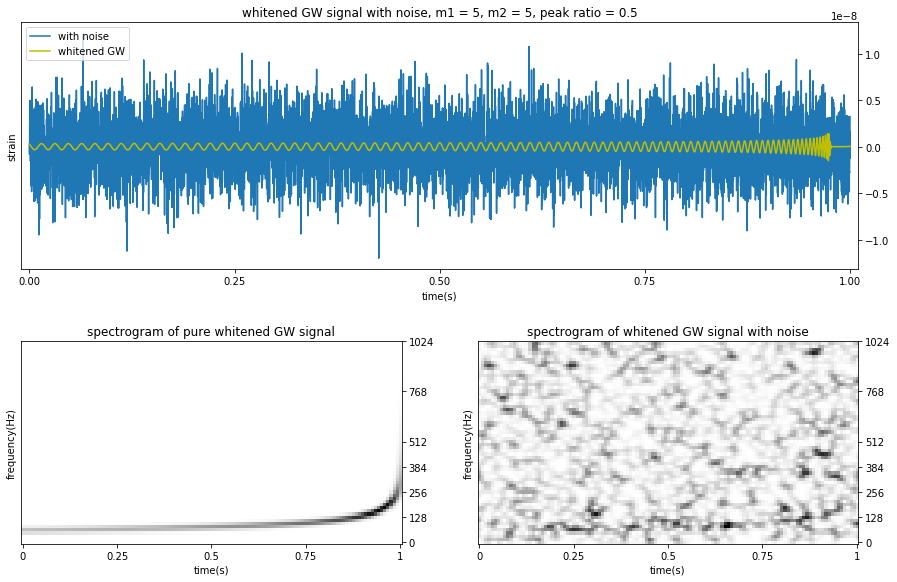

In [46]:
wavepicture2(5, 5, 50, 0.5)

len hp = 23411
avg SNR = 0.006580094281432647
peak Amplitude ratio = 0.48978253074037087
peak SNR = 0.23988692741844234


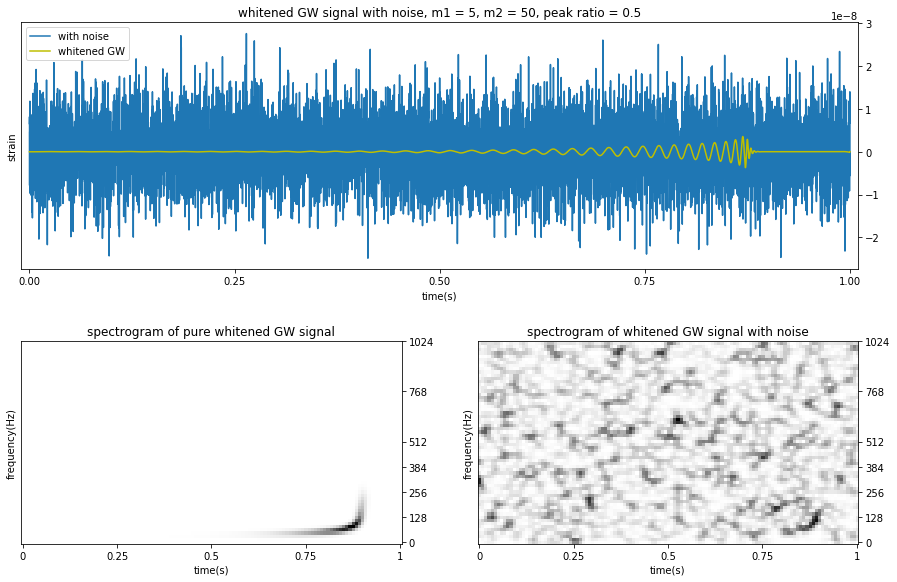

In [52]:
wavepicture2(5, 50, 20, 0.5)

len hp = 12097
avg SNR = 0.0025538569750742294
peak Amplitude ratio = 0.5021088142753839
peak SNR = 0.2521132613730319


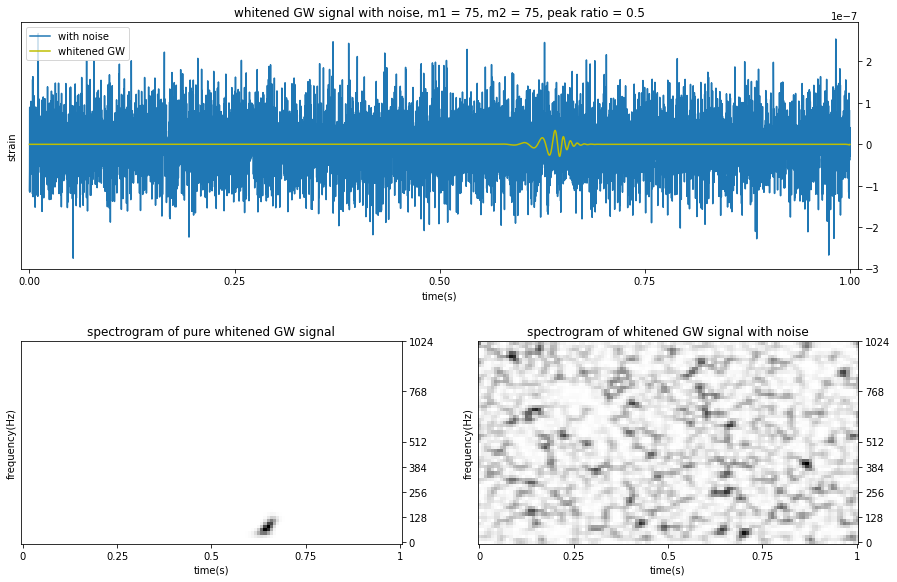

In [44]:
wavepicture2(75, 75, 10, 0.5)

len hp = 36127
avg SNR = 0.004723003392728114
peak Amplitude ratio = 0.498829147113509
peak SNR = 0.24883051800999081


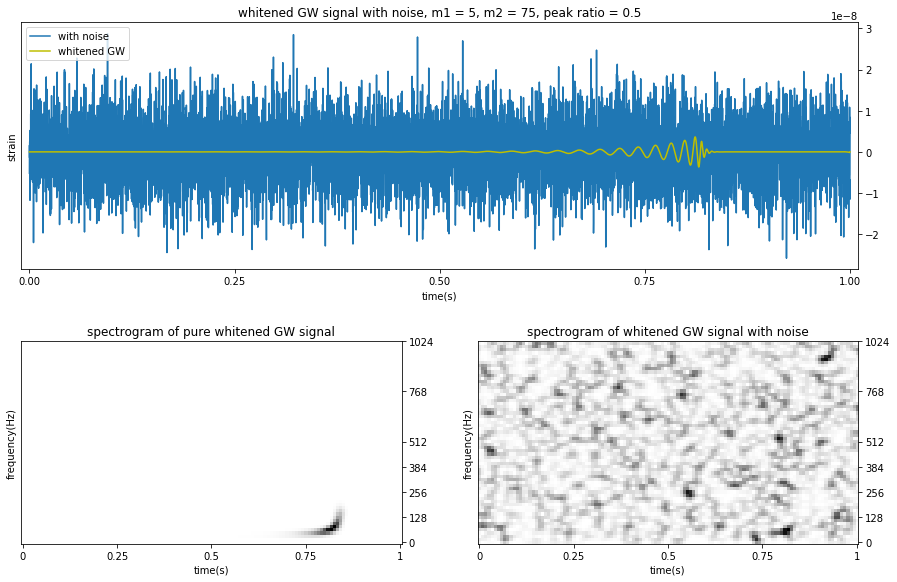

In [45]:
wavepicture2(5, 75, 15, 0.5)

len hp = 28815
avg SNR = 0.02906537968627942
peak Amplitude ratio = 1.0124403540210114
peak SNR = 1.025035470450191


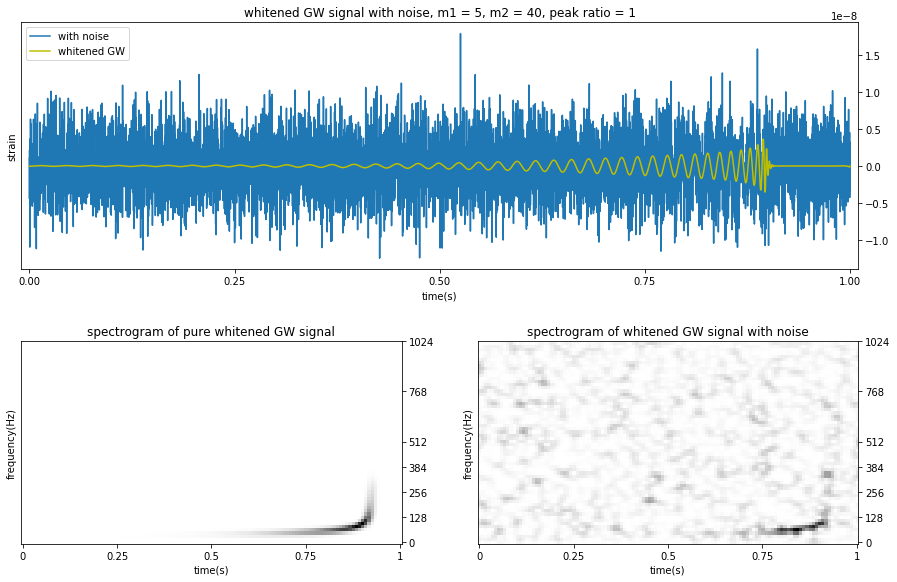

In [35]:
wavepicture2(5, 40, 20, 1)

len hp = 18632
avg SNR = 0.012464774557219145
peak Amplitude ratio = 0.9958430684077068
peak SNR = 0.9917034168956765


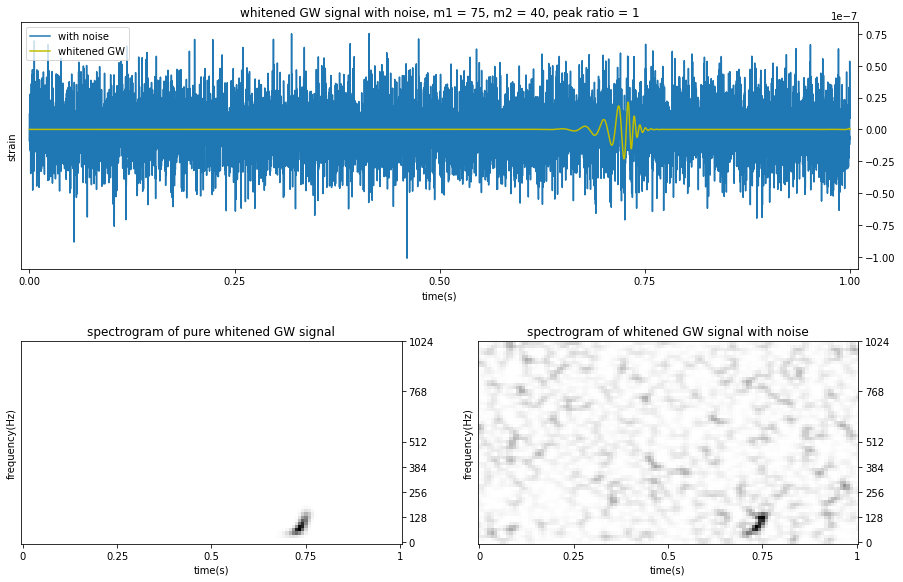

In [36]:
wavepicture2(75, 40, 10, 1)

# Whiten GW waveform

In [5]:
def singleGW(m1,m2):
    total_mass = m1+m2
    if total_mass <= 11 : fl = 45
    elif total_mass <= 14 : fl =40
    elif total_mass <= 17 : fl =35
    elif total_mass <= 23 : fl =30
    elif total_mass <= 34 : fl =25
    elif total_mass <= 54 : fl =20
    elif total_mass <= 90 : fl =15
    else : fl =10
    hp, hc = get_td_waveform(approximant=approximation,
                                     mass1=m1,
                                     mass2=m2,
                                     f_lower=fl,
                                     delta_t=1.0/sample_rate)
    
    del hc
    start_index = len(hp) - data_length
    end_index = len(hp)
    hp = hp[start_index:end_index]
    # whitening
    hpw = whiten(hp, psd_smooth, dt)
    return hpw

# Generate the GW template bank

In [7]:
def GWgenerator(mmin, mmax, deltam, filename): 
    #計時
    start_time = timeit.default_timer()
    #建立存放資料的檔案
    f = h5py.File(filename,'w')
    #設定存放格式
    maxmin = (mmax-mmin)/deltam
    num = maxmin*(maxmin+1)/2+(maxmin+1) -30#for5.5~74.5 mr小於10的數目  #-31#for5~75 mr小於10的數目
    f.create_dataset('data', (num,data_length), maxshape=(None,data_length))
    f.create_dataset('parameter', (num,2), maxshape=(None,2))

    j = 0
    m1 = mmin * 1
    while m1 <= mmax:
        m2 = m1 *1
        while m2 <= mmax:
            if m2/m1 <= 10.:#取mass ratio小於10
                total_mass = m1+m2
                if total_mass <= 11 : fl = 45
                elif total_mass <= 14 : fl =40
                elif total_mass <= 17 : fl =35
                elif total_mass <= 23 : fl =30
                elif total_mass <= 34 : fl =25
                elif total_mass <= 54 : fl =20
                elif total_mass <= 90 : fl =15
                else : fl =10
                
                hp, hc = get_td_waveform(approximant=approximation,
                                     mass1=m1,
                                     mass2=m2,
                                     f_lower=fl,
                                     delta_t=1.0/sample_rate)
                del hc
                start_index = len(hp) - data_length
                end_index = len(hp)
                hp = hp[start_index:end_index]
            
                # whitening
                hp = whiten(hp, psd_smooth, dt)
            
                #Resize
                #if j > 2556 : 
                #    lenth = f['label'].shape[0]
                #    f['data'].resize([lenth+10, data_length])
                #    f['label'].resize([lenth+10, 2])
                f['data'][j] = hp.reshape(1,data_length) 
                f['parameter'][j] = np.array([[m1, m2]])
            
                j += 1
                if j%500==0:
                    print(j)
            m2 = m2 + deltam
            
        m1 = m1 + deltam
        
    f.close()
    stop_time = timeit.default_timer()
    print stop_time - start_time,'s'

In [86]:
GWgenerator(5, 75, 1, '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

500
1000
1500
2000
2500
528.939237118 s


In [95]:
GWgenerator(5.5, 74.5, 1, '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

500
1000
1500
2000
474.789998055 s


(2455, 8192)
(2455, 2)
2455
[74.5 74.5]


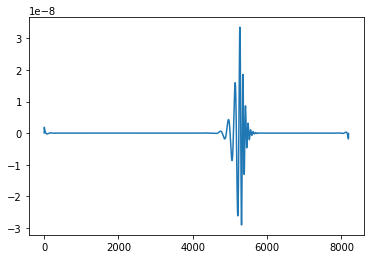

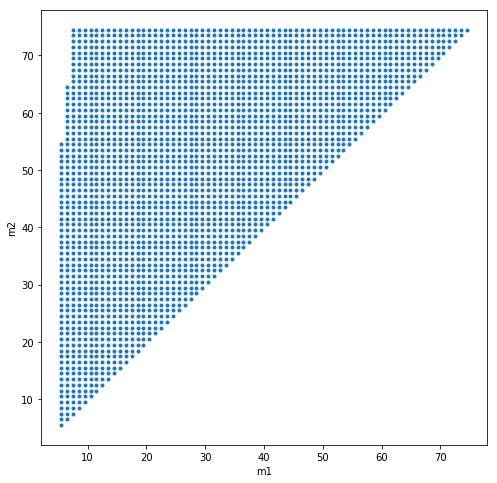

In [107]:
f = h5py.File('/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10','r')
print f['data'].shape
print f['parameter'].shape
print len(f['parameter'])
I = f['parameter'][...]
print I[2454]
plt.plot(f['data'][2454])
plt.figure(figsize=(8,8))
plt.plot(f['parameter'][:,0],f['parameter'][:,1] , '.')
plt.xlabel('m1')
plt.ylabel('m2')
f.close()

(2525, 8192)
(2525, 2)
2525
[75. 75.]


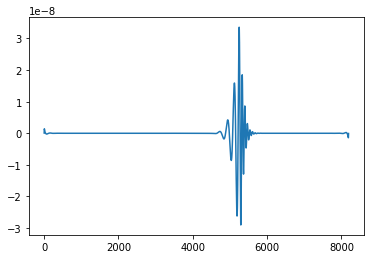

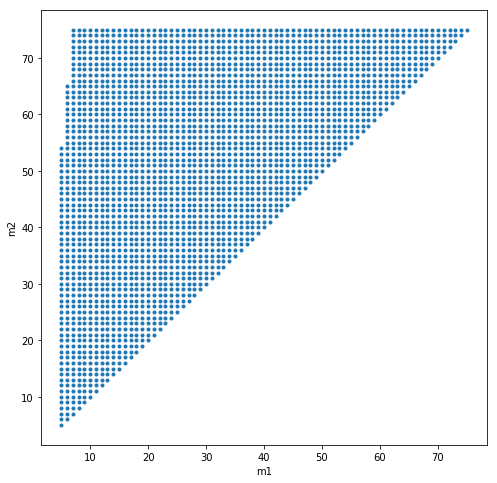

In [108]:
f = h5py.File('/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10','r')
print f['data'].shape
print f['parameter'].shape
print len(f['parameter'])
I = f['parameter'][...]
print I[2524]
plt.plot(f['data'][2524])
plt.figure(figsize=(8,8))
plt.plot(f['parameter'][:,0],f['parameter'][:,1] , '.')
plt.xlabel('m1')
plt.ylabel('m2')
f.close()

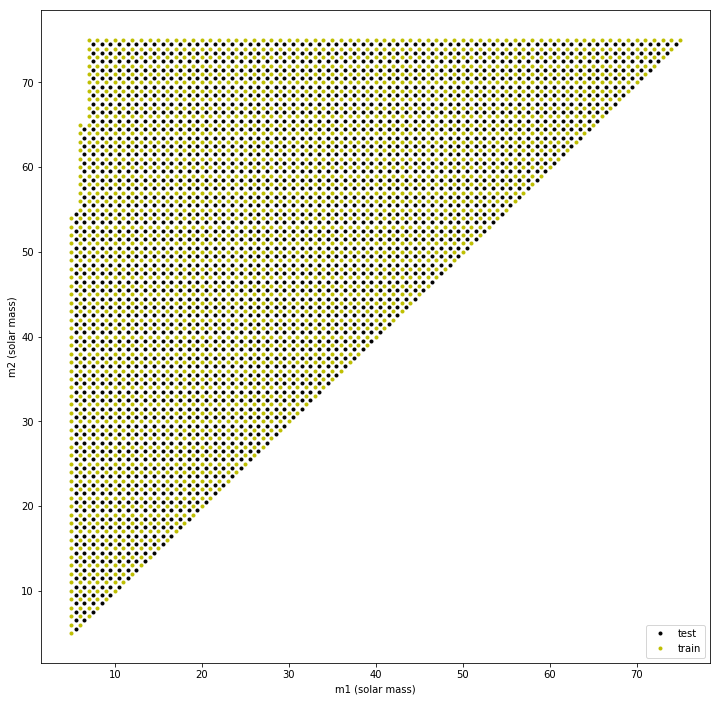

In [83]:
f = h5py.File('/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10','r')
g = h5py.File('/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10','r')
plt.figure(figsize=(12,12))
plt.plot(f['parameter'][:,0],f['parameter'][:,1] , '.k', label='test')
plt.plot(g['parameter'][:,0],g['parameter'][:,1] , '.y', label='train')
plt.legend(loc='lower right')
plt.xlabel('m1 (solar mass)')
plt.ylabel('m2 (solar mass)')
f.close()

# Important sampling

In [6]:
def metropolis(num,initial, pdf):
    xold = initial
    l = []
    while len(l) < num:
        xnew = np.random.random_sample()
        condition = np.random.random_sample()
        if pdf(xnew) >= pdf(xold):
            xold = xnew*1
            l = np.append(l, xold)
        elif pdf(xnew) / pdf(xold) >= condition:
            xold = xnew*1
            l = np.append(l, xold)
    return l

# Generate the GW data with the random sampling masses

In [7]:
def datagenerator(peakratio, num, percentage_of_noise, filename, gwdata=None, massrange=None, pdf=None): 
    #計時
    start_time = timeit.default_timer()
    #建立存放資料的檔案
    f = h5py.File(filename,'w')
    #設定存放格式
    f.create_dataset('data', (num,data_length))
    f.create_dataset('parameter', (num,2))
    f.create_dataset('label', (num,))
    if gwdata != None: #載入pure GW data
        g = h5py.File(gwdata,'r')
        waveformamount = len(g['parameter'])
    #資料筆數的亂數排列
    p = np.random.permutation(num)
    num_waveform = int(num*(1.-percentage_of_noise))
    
    
    #從massrange 的範圍中產生mass combination
    if type(massrange)==list: #從massrange 的範圍中隨機取一組mass
        
        #對單一pr產生資料
        if type(peakratio)==float or type(peakratio)==int :
            print '單一pr，massrange'
            #產生num組資料
            for j in range(num):
                #隨機產生0或1的數字，有無訊號的數據比例為1:1
                #yesornot = np.random.randint(0,2)
                #f['label'][j] = yesornot #將label加入檔案中
                #if yesornot==1: #產生有訊號數據
                if p[j] < num_waveform: #產生有訊號的數據
                    m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    while m2r/m1r < 1. or 10. < m2r/m1r : #產生mass ratio 介於1~10之間的組合
                        m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                        m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    m1 = float('%.1f'%m1r)
                    m2 = float('%.1f'%m2r)
                    hp = singleGW(m1,m2)
                    hp_max = max(hp)
                    noise = np.random.normal(0, 1./peakratio * hp_max, data_length) #根據pr 產生noise
                    hp_noise = hp + noise
                    #將有訊號數據加入檔案中 
                    f['data'][j] = hp_noise.reshape(1,data_length)
                    f['parameter'][j] = np.array([[m1, m2]])
                    f['label'][j] = 1
                    
                else: #產生無訊號數據
                    pure_noise = np.random.normal(0, 1, data_length)
                    f['data'][j] = pure_noise.reshape(1, data_length) #將無訊號數據加入檔案中
                    f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                    f['label'][j] = 0
            
        
        #對範圍內pr產生資料
        elif type(peakratio)==list :
            print '範圍pr，massrange'
            if pdf != None: #若有指定pdf，產生num個機率分布為pdf的pr
                sampling = metropolis(num, (peakratio[1]+peakratio[0])/2, pdf)
            
            i = 1
            for j in range(num):
                #隨機產生0或1的數字，有無訊號的數據比例為1:1
                #yesornot = np.random.randint(0,2) 
                #f['label'][j] = yesornot #將label加入檔案中
                #if yesornot==1: #產生有訊號的數據
                if p[j] < num_waveform: #產生有訊號的數據
                    #產生隨機peakratio
                    if pdf == None: #產生機率分布為uniform distribution的pr
                        randpeakratio = np.random.sample() * np.abs(peakratio[1]-peakratio[0]) + np.min(peakratio)
                    else:
                        randpeakratio = sampling[i]
                        i += 1
                    m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    while m2r/m1r < 1. or 10. < m2r/m1r : #產生mass ratio 介於1~10之間的組合
                        m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                        m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                    m1 = float('%.1f'%m1r)
                    m2 = float('%.1f'%m2r)
                    hp = singleGW(m1,m2)
                    hp_max = max(hp)
                    noise = np.random.normal(0, 1./randpeakratio * hp_max, data_length) #根據rand pr 產生noise
                    hp_noise = hp + noise
                    #將有訊號數據加入檔案中 
                    f['data'][j] = hp_noise.reshape(1,data_length)
                    f['parameter'][j] = np.array([[m1, m2]])
                    f['label'][j] = 1

                else: #產生無訊號的數據
                    pure_noise = np.random.normal(0, 1, data_length)
                    f['data'][j] = pure_noise.reshape(1, data_length) #將無訊號數據加入檔案中
                    f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                    f['label'][j] = 0
                if j%5000==0.:print(j)
            
    
    
    #從templet bank 取mass combination
    else:
        
        #對單一pr產生資料
        if type(peakratio)==float or type(peakratio)==int :
            print '單一pr，templet bank'
            #產生num組資料
            for j in range(num):
                #隨機產生0或1的數字，有無訊號的數據比例為1:1
                #yesornot = np.random.randint(0,2)
                #f['label'][j] = yesornot #將label加入檔案中
                #if yesornot==1: #產生有訊號數據
                if p[j] < num_waveform: #產生有訊號的數據
                    nn = np.random.randint(0,waveformamount)
                    hp = g['data'][nn] #從templet bank 隨機取一組mass
                    hp_max = max(hp)
                    noise = np.random.normal(0, 1./peakratio * hp_max, data_length) #根據pr 產生noise
                    hp_noise = hp + noise
                    #將有訊號數據加入檔案中 
                    f['data'][j] = hp_noise.reshape(1,data_length)
                    f['parameter'][j] = g['parameter'][nn]
                    f['label'][j] = 1
                
                else: #產生無訊號數據
                    pure_noise = np.random.normal(0, 1, data_length)
                    f['data'][j] = pure_noise.reshape(1, data_length) #將無訊號數據加入檔案中
                    f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                    f['label'][j] = 0
    
        #對範圍內pr產生資料
        elif type(peakratio)==list :
            print '範圍pr，templet bank'
            if pdf != None: #若有指定pdf，產生num個機率分布為pdf的pr
                sampling = metropolis(num, (peakratio[1]+peakratio[0])/2, pdf)
                i = 1
                
            for j in range(num):
                #隨機產生0或1的數字，有無訊號的數據比例為1:1
                #yesornot = np.random.randint(0,2) 
                #f['label'][j] = yesornot
                #if yesornot==1: #產生有訊號的數據
                if p[j] < num_waveform: #產生有訊號的數據
                    #產生隨機peakratio
                    if pdf == None: #產生機率分布為uniform distribution的pr
                        randpeakratio = np.random.sample() * np.abs(peakratio[1]-peakratio[0]) + np.min(peakratio)
                    else:
                        randpeakratio = sampling[i]
                        i += 1
                    nn = np.random.randint(0,waveformamount)
                    hp = g['data'][nn] #從templet bank 隨機取一組mass
                    hp_max = max(hp)
                    noise = np.random.normal(0, 1./randpeakratio * hp_max, data_length) #根據rand pr 產生noise
                    hp_noise = hp + noise
                    #將有訊號數據加入檔案中 
                    f['data'][j] = hp_noise.reshape(1,data_length) 
                    f['parameter'][j] = g['parameter'][nn]
                    f['label'][j] = 1

                else: #產生無訊號的數據
                    pure_noise = np.random.normal(0, 1, data_length)
                    f['data'][j] = pure_noise.reshape(1, data_length) #將無訊號數據加入檔案中
                    f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                    f['label'][j] = 0
        g.close()
    
    f.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    print('finish')

In [64]:
datagenerator(1,10,0.5,'/Volumes/Mac/GW/time/test1.h5','/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

單一pr，templet bank
period(s) = 0.673517942429
finish


In [68]:
datagenerator([1,5],10,0.5,'/Volumes/Mac/GW/time/test2.h5','/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

範圍pr，templet bank
period(s) = 0.311127901077
finish


In [71]:
datagenerator(1,10,0.5,'/Volumes/Mac/GW/time/test3.h5',massrange=[5,15])

單一pr，massrange
period(s) = 1.27327299118
finish


In [72]:
datagenerator([1,5],10,0.5,'/Volumes/Mac/GW/time/test3.h5',massrange=[5,15])

範圍pr，massrange
period(s) = 1.25442504883
finish


val data

In [101]:
prlist = [2,1.5,1.2,1,0.8,0.7,0.6,0.5]
for n in prlist:
    datagenerator(n, 3000, '/Volumes/Mac/GW/time/overlap/5~75/validationdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')


period(s) = 13.8467490673
finish
period(s) = 13.8346610069
finish
period(s) = 13.1808838844
finish
period(s) = 13.2981719971
finish
period(s) = 12.9767870903
finish
period(s) = 13.2909929752
finish
period(s) = 12.6473879814
finish
period(s) = 13.3585340977
finish


In [10]:
prlist = [1.7, 1.4, 1.3, 1.1, 0.9, 0.85, 0.75, 0.65, 0.55]
for n in prlist:
    datagenerator(n, 3000, '/Volumes/Mac/GW/time/overlap/5~75/validationdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

period(s) = 11.1578831673
finish
period(s) = 10.4707200527
finish
period(s) = 10.0598161221
finish
period(s) = 9.57258319855
finish
period(s) = 9.42482209206
finish
period(s) = 11.2700669765
finish
period(s) = 12.0488181114
finish
period(s) = 11.3890788555
finish
period(s) = 11.1332938671
finish


final train data

In [146]:
datagenerator([0.5, 1.5], 3000, '/Volumes/Mac/GW/time/overlap/5~75/finalvalidationdata_time.h5', massrange=[5.,75.])

範圍pr，massrange
period(s) = 329.034726143
finish


In [135]:
datagenerator([0.5, 1.5], 30000, '/Volumes/Mac/GW/time/overlap/5~75/finaltrainingdata_time.h5', massrange=[5.,75.])

範圍pr，massrange
period(s) = 3011.693398
finish


In [19]:
datagenerator([0.5, 1.5], 30000, '/Volumes/Mac/GW/time/overlap/5~75/finaltestdata_time.h5', massrange=[5.,75.])

範圍pr，massrange
period(s) = 6948.25804782
finish


In [45]:
ff=h5py.File('/Volumes/Mac/GW/time/overlap/5~75/finaltrainingdata_time.h5','r')
print ff.keys()
i=29009
print ff['parameter'][i]
print ff['data'][i]
print ff['label'][i]
ff.close()

[u'data', u'label', u'parameter']
[65.5 66.2]
[3.1382793e-08 3.0004315e-08 2.7499990e-08 ... 2.3610825e-08 1.4648067e-09
 1.7512516e-08]
1.0


In [ ]:
datagenerator([0.4, 1.2], 300000, 0.5, '/Volumes/Mac/GW/time/overlap/5~75/finaltrainingdata_time_30W.h5', massrange=[5.,75.])

In [ ]:
datagenerator([0.4, 1.2], 300000, 0.5, '/Volumes/Mac/GW/time/overlap/5~75/finaltestdata_time_30W.h5', massrange=[5.,75.])

# Generate the GW data from template bank without repeating mass combination

In [11]:
def datagenerator_wrtb(peakratio, percentage_of_noise, multi, filename, gwdata, pdf=None): 
    #計時
    start_time = timeit.default_timer()
    #建立存放資料的檔案
    f = h5py.File(filename,'w')
    #載入GW data
    g = h5py.File(gwdata,'r')
    num_waveform = multi * len(g['parameter'])
    num = int(num_waveform/(1.-percentage_of_noise))
    #設定存放格式
    f.create_dataset('data', (num,data_length))
    f.create_dataset('label', (num,))
    f.create_dataset('parameter', (num,2))
    #資料筆數的亂數排列
    p = np.random.permutation(num)
    
    
    #對單一pr產生資料
    if type(peakratio)==float or int :
        print '單一pr，templet bank'
        for j in range(num):
            if p[j] < num_waveform: #有訊號的數據
                index = p[j] % len(g['parameter'])
                f['label'][j] = 1
                f['parameter'][j] = g['parameter'][index]
                hp = g['data'][index]
                hp_max = max(hp)
                noise = np.random.normal(0, 1./peakratio * hp_max, data_length) #根據rand pr 產生noise
                hp_noise = hp + noise
                f['data'][j] = hp_noise.reshape(1,data_length) 
                 
            else: #無訊號的數據
                f['label'][j] = 0
                f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                pure_noise = np.random.normal(0, 1, data_length)
                f['data'][j] = pure_noise.reshape(1, data_length)
                
    
    #對範圍內pr產生資料
    elif type(peakratio)==list :
        print '範圍pr，templet bank'
        if pdf != None: #若有指定pdf，產生num個機率分布為pdf的pr
            sampling = metropolis(num, (peakratio[1]+peakratio[0])/2, pdf)
            i = 1
        for j in range(num):
            if p[j] < num_waveform: #有訊號的數據
                index = p[j] % len(g['parameter'])
                f['label'][j] = 1
                f['parameter'][j] = g['parameter'][index]
                hp = g['data'][index]
                if pdf == None: #產生機率分布為uniform distribution的pr
                    randpeakratio = np.random.sample() * np.abs(peakratio[1]-peakratio[0]) + np.min(peakratio)
                else:
                    randpeakratio = sampling[i]
                    i += 1
                hp_max = max(hp)
                noise = np.random.normal(0, 1./randpeakratio * hp_max, data_length) #根據rand pr 產生noise
                hp_noise = hp + noise
                f['data'][j] = hp_noise.reshape(1,data_length)
                 
            else: #無訊號的數據
                f['label'][j] = 0
                f['parameter'][j] = np.array([[float('%.1f'%0), float('%.1f'%0)]])
                pure_noise = np.random.normal(0, 1, data_length)
                f['data'][j] = pure_noise.reshape(1, data_length)
    
    
    f.close()
    g.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    print('finish')

training data

In [103]:
for n in prlist:
    datageneratorwo(n, 0.6, 1, '/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

period(s) = 27.6498541832
finish
period(s) = 27.1596570015
finish
period(s) = 26.8455431461
finish
period(s) = 38.4370501041
finish
period(s) = 29.8596739769
finish
period(s) = 28.3523199558
finish
period(s) = 29.7878489494
finish
period(s) = 28.0908989906
finish


In [11]:
for n in prlist:
    datageneratorwo(n, 0.6, 1, '/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

period(s) = 30.0909600258
finish
period(s) = 27.2559759617
finish
period(s) = 29.9009239674
finish
period(s) = 28.6218099594
finish
period(s) = 28.5512478352
finish
period(s) = 28.9155619144
finish
period(s) = 31.5481078625
finish
period(s) = 33.3932688236
finish
period(s) = 33.2371881008
finish


test data

In [104]:
for n in prlist:
    datageneratorwo(n, 0.6, 1, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

period(s) = 28.3058519363
finish
period(s) = 27.1472737789
finish
period(s) = 24.5616440773
finish
period(s) = 23.7664830685
finish
period(s) = 23.9199609756
finish
period(s) = 23.7248032093
finish
period(s) = 23.9355289936
finish
period(s) = 24.6022090912
finish


In [12]:
for n in prlist:
    datageneratorwo(n, 0.6, 1, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(n)+'_mr<=10.h5', 
              '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

period(s) = 33.0922019482
finish
period(s) = 33.7740900517
finish
period(s) = 27.7991480827
finish
period(s) = 29.0340118408
finish
period(s) = 30.0898370743
finish
period(s) = 31.1297199726
finish
period(s) = 32.7533428669
finish
period(s) = 32.2202270031
finish
period(s) = 28.4499149323
finish


In [18]:
m=0.5
for i in range(50):
    datageneratorwo(m, 0.1, 2, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr'+str(m)+'_2time10_'+str(i)+'_mr<=10.h5',
                    '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

period(s) = 37.3811850548
finish
period(s) = 35.3309149742
finish
period(s) = 36.1928958893
finish
period(s) = 35.2398028374
finish
period(s) = 35.9177708626
finish
period(s) = 34.1106450558
finish
period(s) = 35.9205999374
finish
period(s) = 36.0167210102
finish
period(s) = 34.9656300545
finish
period(s) = 36.1973309517
finish
period(s) = 37.3391208649
finish
period(s) = 33.6800789833
finish
period(s) = 42.2137060165
finish
period(s) = 33.1064970493
finish
period(s) = 33.0102570057
finish
period(s) = 32.576638937
finish
period(s) = 34.9903719425
finish
period(s) = 32.7795979977
finish
period(s) = 35.6002840996
finish
period(s) = 33.5894680023
finish
period(s) = 32.3521318436
finish
period(s) = 33.4668879509
finish
period(s) = 32.2871940136
finish
period(s) = 31.8206179142
finish
period(s) = 32.56310606
finish
period(s) = 31.6909649372
finish
period(s) = 31.146739006
finish
period(s) = 31.5458688736
finish
period(s) = 37.8185479641
finish
period(s) = 35.6637001038
finish
period(s) = 35

In [9]:
prlist = []
ns=0.1
for i in range(39):
    print '{0:.2f}   {1:.2f}   {2:.2f}'.format(ns, 1/ns, 1/ns*10)
    prlist.append('{:.2f}'.format(1/ns))
    ns += 0.05

0.10   10.00   100.00
0.15   6.67   66.67
0.20   5.00   50.00
0.25   4.00   40.00
0.30   3.33   33.33
0.35   2.86   28.57
0.40   2.50   25.00
0.45   2.22   22.22
0.50   2.00   20.00
0.55   1.82   18.18
0.60   1.67   16.67
0.65   1.54   15.38
0.70   1.43   14.29
0.75   1.33   13.33
0.80   1.25   12.50
0.85   1.18   11.76
0.90   1.11   11.11
0.95   1.05   10.53
1.00   1.00   10.00
1.05   0.95   9.52
1.10   0.91   9.09
1.15   0.87   8.70
1.20   0.83   8.33
1.25   0.80   8.00
1.30   0.77   7.69
1.35   0.74   7.41
1.40   0.71   7.14
1.45   0.69   6.90
1.50   0.67   6.67
1.55   0.65   6.45
1.60   0.62   6.25
1.65   0.61   6.06
1.70   0.59   5.88
1.75   0.57   5.71
1.80   0.56   5.56
1.85   0.54   5.41
1.90   0.53   5.26
1.95   0.51   5.13
2.00   0.50   5.00


In [47]:
prlist

['10.00',
 '6.67',
 '5.00',
 '4.00',
 '3.33',
 '2.86',
 '2.50',
 '2.22',
 '2.00',
 '1.82',
 '1.67',
 '1.54',
 '1.43',
 '1.33',
 '1.25',
 '1.18',
 '1.11',
 '1.05',
 '1.00',
 '0.95',
 '0.91',
 '0.87',
 '0.83',
 '0.80',
 '0.77',
 '0.74',
 '0.71',
 '0.69',
 '0.67',
 '0.65',
 '0.62',
 '0.61',
 '0.59',
 '0.57',
 '0.56',
 '0.54',
 '0.53',
 '0.51',
 '0.50']

In [14]:
datagenerator_wrtb(0.5, 0, 50, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_error_relate_mass.h5', 
                   '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

單一pr，templet bank
period(s) = 795.577996969
finish


In [48]:
for i in prlist:
    pr=float(i)
    datagenerator_wrtb(pr, 0.5, 1, '/Volumes/Mac/GW/time/withoutoverlap/5~75/trainingdata_time_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

單一pr，templet bank
period(s) = 24.51060009
finish
單一pr，templet bank
period(s) = 21.669782877
finish
單一pr，templet bank
period(s) = 21.75770998
finish
單一pr，templet bank
period(s) = 21.5886609554
finish
單一pr，templet bank
period(s) = 22.3616330624
finish
單一pr，templet bank
period(s) = 24.8395490646
finish
單一pr，templet bank
period(s) = 25.5401301384
finish
單一pr，templet bank
period(s) = 23.2273938656
finish
單一pr，templet bank
period(s) = 23.9162478447
finish
單一pr，templet bank
period(s) = 22.354019165
finish
單一pr，templet bank
period(s) = 22.6498780251
finish
單一pr，templet bank
period(s) = 23.8503880501
finish
單一pr，templet bank
period(s) = 23.3765239716
finish
單一pr，templet bank
period(s) = 23.2650840282
finish
單一pr，templet bank
period(s) = 22.5989029408
finish
單一pr，templet bank
period(s) = 22.443253994
finish
單一pr，templet bank
period(s) = 23.5586769581
finish
單一pr，templet bank
period(s) = 22.8602228165
finish
單一pr，templet bank
period(s) = 22.4275588989
finish
單一pr，templet bank
period(s) = 21.91878

In [49]:
for i in prlist:
    pr=float(i)
    datagenerator_wrtb(pr, 0.5, 1, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

單一pr，templet bank
period(s) = 22.2397260666
finish
單一pr，templet bank
period(s) = 21.1057460308
finish
單一pr，templet bank
period(s) = 21.1885449886
finish
單一pr，templet bank
period(s) = 21.1801979542
finish
單一pr，templet bank
period(s) = 22.2356908321
finish
單一pr，templet bank
period(s) = 21.060958147
finish
單一pr，templet bank
period(s) = 21.2313630581
finish
單一pr，templet bank
period(s) = 21.2239878178
finish
單一pr，templet bank
period(s) = 21.0679728985
finish
單一pr，templet bank
period(s) = 21.2127571106
finish
單一pr，templet bank
period(s) = 22.0373039246
finish
單一pr，templet bank
period(s) = 21.1117620468
finish
單一pr，templet bank
period(s) = 21.0311710835
finish
單一pr，templet bank
period(s) = 21.4646120071
finish
單一pr，templet bank
period(s) = 21.1540541649
finish
單一pr，templet bank
period(s) = 21.7474188805
finish
單一pr，templet bank
period(s) = 21.8073840141
finish
單一pr，templet bank
period(s) = 21.3429629803
finish
單一pr，templet bank
period(s) = 21.1904981136
finish
單一pr，templet bank
period(s) = 21

[62.5 66.5]


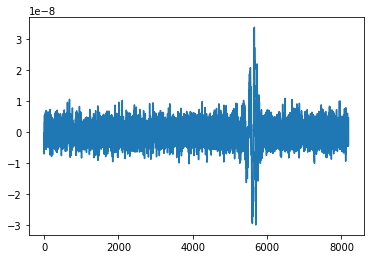

In [51]:
f = h5py.File('/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5/testdata_time_pr10.00.h5','r')
k=2
print f['parameter'][k]
plt.plot(f['data'][k])
f.close()

In [11]:
#遞迴寫法
def randommass_wrr(massrange, total): 
    masslist = []
    count=0
    def generaterandom_withoutrepeat(n):
        if n<total: #檢查總數是否達到total
            m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
            m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
            while m2r/m1r < 1. or 10. < m2r/m1r : #產生mass ratio 介於1~10之間的組合
                m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
                m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
        
            temporary = [float('%.1f'%m1r), float('%.1f'%m2r)]; #暫時的mass combination
            if temporary not in masslist: #檢查暫時的組合是否已存在於list中
                masslist.append(temporary); #不存在的話就將暫時的組合存到list中
                n += 1 #有效組合數加一
            generaterandom_withoutrepeat(n) #繼續產生下一個組合
    generaterandom_withoutrepeat(count)
    return np.array(masslist)

In [13]:
#迴圈寫法
def randommass_wrl(massrange, total): 
    masslist = []
    count=0
    while count<total: #檢查總數是否達到total，未達到就繼續產生下一個組合
        m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
        m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
        while m2r/m1r < 1. or 10. < m2r/m1r : #產生mass ratio 介於1~10之間的組合
            m1r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
            m2r = np.random.random() * np.abs(massrange[1]-massrange[0]) + np.min(massrange)
    
        temporary = [float('%.1f'%m1r), float('%.1f'%m2r)]; #暫時的mass combination
        if temporary not in masslist: #檢查暫時的組合是否已存在於list中
            masslist.append(temporary); #不存在的話就將暫時的組合存到list中
            count += 1 #有效組合數加一

    return np.array(masslist)

# Generate the GW data from the given mass range without repeating mass combination

In [11]:
def datagenerator_wrmr(peakratio, num, percentage_of_noise, filename, massrange, pdf=None): 
    #計時
    start_time = timeit.default_timer()
    #建立存放資料的檔案
    f = h5py.File(filename,'w')
    #設定存放格式
    f.create_dataset('data', (num,data_length))
    f.create_dataset('parameter', (num,2))
    f.create_dataset('label', (num,))
    num_waveform = int(num*(1-percentage_of_noise))
    mlist = randommass_wrl(massrange, num_waveform)
    #資料筆數的亂數排列
    p = np.random.permutation(num)
    
    #對單一pr產生資料
    if type(peakratio)==float or int :
        print '單一pr，massrange'
        for j in range(num):
            if p[j] < num_waveform: #有訊號的數據
                index = p[j]
                f['label'][j] = 1
                f['parameter'][j] = mlist[index]
                hp = singleGW(mlist[index,0],mlist[index,1])
                hp_max = max(hp)
                noise = np.random.normal(0, 1./peakratio * hp_max, data_length) #根據rand pr 產生noise
                hp_noise = hp + noise
                f['data'][j] = hp_noise.reshape(1,data_length) 
                 
            else: #無訊號的數據
                f['label'][j] = 0
                f['parameter'][j] = np.array([float('%.1f'%0), float('%.1f'%0)])
                pure_noise = np.random.normal(0, 1, data_length)
                f['data'][j] = pure_noise.reshape(1, data_length)
                
    
    #對範圍內pr產生資料
    elif type(peakratio)==list :
        print '範圍pr，massrange'
        if pdf != None: #若有指定pdf，產生num個機率分布為pdf的pr
            sampling = metropolis(num, (peakratio[1]+peakratio[0])/2, pdf)
            i = 1
        for j in range(num):
            if p[j] < num_waveform: #有訊號的數據
                index = p[j]
                f['label'][j] = 1
                f['parameter'][j] = mlist[index]
                hp = singleGW(mlist[index,0],mlist[index,1])
                if pdf == None: #產生機率分布為uniform distribution的pr
                    randpeakratio = np.random.sample() * np.abs(peakratio[1]-peakratio[0]) + np.min(peakratio)
                else:
                    randpeakratio = sampling[i]
                    i += 1
                hp_max = max(hp)
                noise = np.random.normal(0, 1./randpeakratio * hp_max, data_length) #根據rand pr 產生noise
                hp_noise = hp + noise
                f['data'][j] = hp_noise.reshape(1,data_length)
                 
            else: #無訊號的數據
                f['label'][j] = 0
                f['parameter'][j] = np.array([float('%.1f'%0), float('%.1f'%0)])
                pure_noise = np.random.normal(0, 1, data_length)
                f['data'][j] = pure_noise.reshape(1, data_length)
    
    
    f.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    print('finish')

In [58]:
for i in prlist:
    pr=float(i)
    datagenerator_wrmr(pr, 2000, 0.5, '/Volumes/Mac/GW/time/withoutoverlap/5~75/validationdata_time_pr{0}.h5'.format(i), 
              [5.,75.])

單一pr，massrange
period(s) = 195.827295065
finish
單一pr，massrange
period(s) = 192.660691023
finish
單一pr，massrange
period(s) = 193.361452818
finish
單一pr，massrange
period(s) = 192.012435913
finish
單一pr，massrange
period(s) = 192.485531092
finish
單一pr，massrange
period(s) = 193.045185089
finish
單一pr，massrange
period(s) = 202.353371143
finish
單一pr，massrange
period(s) = 206.683254004
finish
單一pr，massrange
period(s) = 190.028127909
finish
單一pr，massrange
period(s) = 189.264878035
finish
單一pr，massrange
period(s) = 188.586990118
finish
單一pr，massrange
period(s) = 195.795759916
finish
單一pr，massrange
period(s) = 197.429919958
finish
單一pr，massrange
period(s) = 200.378694057
finish
單一pr，massrange
period(s) = 202.563424826
finish
單一pr，massrange
period(s) = 200.107076168
finish
單一pr，massrange
period(s) = 196.155001879
finish
單一pr，massrange
period(s) = 197.308160067
finish
單一pr，massrange
period(s) = 200.053533077
finish
單一pr，massrange
period(s) = 198.735591173
finish
單一pr，massrange
period(s) = 197.549842119

In [110]:
np.random.random(3)

array([0.52111897, 0.5799838 , 0.16453332])

In [100]:
n1 = 70 * np.random.random() + 5
n2 = 70 * np.random.random() +5
c=0
while n2/n1 <= 1. or 10 <= n2/n1 :
    n1 = 70 * np.random.random() + 5
    n2 = 70 * np.random.random() +5
    c+=1
print n1, n2, n2/n1, c

6.2307028855 51.6347920415 8.28715363104 6


In [98]:
np.random.randint(5)

3

In [43]:
if type([1.,2.])==float or type([1.,2.])==int:
    print 'y'
else:
    print 'n'

n


In [129]:
float('%.2f'%(np.random.random()*100))

83.3

In [133]:
float('%.1f'%0)

0.0

In [153]:
[float('%.4f'%1.1),1.50]==[1.1,1.5]

True

In [159]:
a=[]
a.append([1,2])
a.append([3,4])
print a

[[1, 2], [3, 4]]


In [169]:
if ([1.,2.] in [[3,4],[1.2,2.2],[6,7]]):
    print 'y'
else:
    print 'n'

n


# Parameter Estimate data

In [12]:
for i in prlist:
    pr=float(i)
    datagenerator_wrtb(pr, 0., 3, '/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/trainingdata_time_PE_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/waveform/GWwaveform5~75_step1_mr<=10')

單一pr，templet bank
period(s) = 49.4503228664
finish
單一pr，templet bank
period(s) = 46.3817138672
finish
單一pr，templet bank
period(s) = 51.4317190647
finish
單一pr，templet bank
period(s) = 50.3993611336
finish
單一pr，templet bank
period(s) = 48.9147398472
finish
單一pr，templet bank
period(s) = 49.7107670307
finish
單一pr，templet bank
period(s) = 49.777930975
finish
單一pr，templet bank
period(s) = 50.5950801373
finish
單一pr，templet bank
period(s) = 46.8814220428
finish
單一pr，templet bank
period(s) = 46.1769521236
finish
單一pr，templet bank
period(s) = 54.5432720184
finish
單一pr，templet bank
period(s) = 46.7077288628
finish
單一pr，templet bank
period(s) = 46.7055640221
finish
單一pr，templet bank
period(s) = 44.8577120304
finish
單一pr，templet bank
period(s) = 44.6858489513
finish
單一pr，templet bank
period(s) = 49.4765841961
finish
單一pr，templet bank
period(s) = 44.7316339016
finish
單一pr，templet bank
period(s) = 45.1264669895
finish
單一pr，templet bank
period(s) = 45.4162700176
finish
單一pr，templet bank
period(s) = 50

In [55]:
for i in prlist:
    pr=float(i)
    datagenerator_wrtb(pr, 0., 1, '/Volumes/Mac/GW/time/withoutoverlap/5.5~74.5_PE/testdata_time_PE_pr{0}.h5'.format(i), 
              '/Volumes/Mac/GW/waveform/GWwaveform5.5~74.5_step1_mr<=10')

單一pr，templet bank
period(s) = 17.7728319168
finish
單一pr，templet bank
period(s) = 16.5934519768
finish
單一pr，templet bank
period(s) = 17.3103408813
finish
單一pr，templet bank
period(s) = 16.167566061
finish
單一pr，templet bank
period(s) = 16.682902813
finish
單一pr，templet bank
period(s) = 16.0146639347
finish
單一pr，templet bank
period(s) = 15.8697359562
finish
單一pr，templet bank
period(s) = 16.813231945
finish
單一pr，templet bank
period(s) = 16.5258719921
finish
單一pr，templet bank
period(s) = 16.7201759815
finish
單一pr，templet bank
period(s) = 16.0597269535
finish
單一pr，templet bank
period(s) = 15.2432889938
finish
單一pr，templet bank
period(s) = 16.8114609718
finish
單一pr，templet bank
period(s) = 16.5949850082
finish
單一pr，templet bank
period(s) = 16.3259599209
finish
單一pr，templet bank
period(s) = 15.675287962
finish
單一pr，templet bank
period(s) = 15.7528440952
finish
單一pr，templet bank
period(s) = 17.4651520252
finish
單一pr，templet bank
period(s) = 16.4101929665
finish
單一pr，templet bank
period(s) = 16.17

(2525, 2)


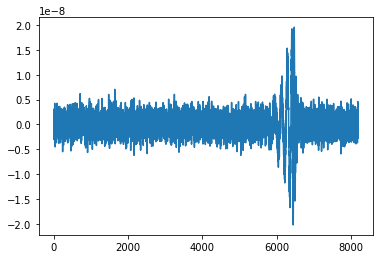

In [58]:
f = h5py.File('/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/trainingdata_time_PE_pr10.00.h5','r')
k=7
print f['parameter'].shape
plt.plot(f['data'][k])
f.close()

In [15]:
for i in prlist:
    pr=float(i)
    datagenerator_wrmr(pr, 1000, 0., '/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/validationdata_time_PE_pr{0}.h5'.format(i), 
              [5.,75.])

單一pr，massrange
period(s) = 188.716726065
finish
單一pr，massrange
period(s) = 185.902819157
finish
單一pr，massrange
period(s) = 185.494894028
finish
單一pr，massrange
period(s) = 184.849059105
finish
單一pr，massrange
period(s) = 184.253843069
finish
單一pr，massrange
period(s) = 184.936377048
finish
單一pr，massrange
period(s) = 196.369235992
finish
單一pr，massrange
period(s) = 205.572808027
finish
單一pr，massrange
period(s) = 196.130332947
finish
單一pr，massrange
period(s) = 187.399955034
finish
單一pr，massrange
period(s) = 191.691987991
finish
單一pr，massrange
period(s) = 197.378142118
finish
單一pr，massrange
period(s) = 194.147821903
finish
單一pr，massrange
period(s) = 192.742703199
finish
單一pr，massrange
period(s) = 190.506607056
finish
單一pr，massrange
period(s) = 199.978390932
finish
單一pr，massrange
period(s) = 196.526424885
finish
單一pr，massrange
period(s) = 198.6238482
finish
單一pr，massrange
period(s) = 198.009824038
finish
單一pr，massrange
period(s) = 186.81832695
finish
單一pr，massrange
period(s) = 185.267465115
fi

(300, 2)


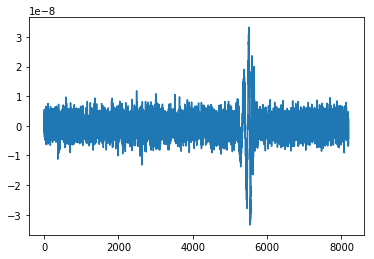

In [61]:
f = h5py.File('/Volumes/Mac/GW/time/withoutoverlap/5~75_PE/validationdata_time_PE_pr10.00.h5','r')
k=7
print f['parameter'].shape
plt.plot(f['data'][k])
f.close()

In [87]:
datagenerator([0.4, 1.5], 60000, 0., '/Volumes/Mac/GW/time/overlap/5~75_PE/finaltrainingdata_time_PE.h5', massrange=[5.,75.])

範圍pr，massrange
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
period(s) = 12250.431633
finish


In [14]:
datagenerator([0.4, 1.5], 20000, 0., '/Volumes/Mac/GW/time/overlap/5~75_PE/finaltestdata_time_PE.h5', massrange=[5.,75.])

範圍pr，massrange
0
5000
10000
15000
period(s) = 5053.18015194
finish


In [86]:
datagenerator([0.4, 1.5], 6000, 0., '/Volumes/Mac/GW/time/overlap/5~75_PE/finalvalidationdata_time_PE.h5', massrange=[5.,75.])

範圍pr，massrange
0
5000
period(s) = 1105.24299598
finish


(20000, 2)
[43.4 73.2]


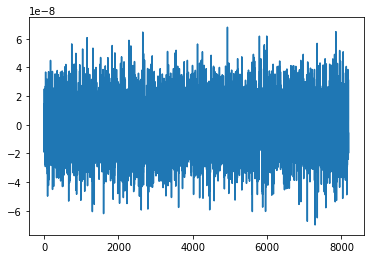

In [19]:
f = h5py.File('/Volumes/Mac/GW/time/overlap/5~75_PE/finaltestdata_time_PE.h5','r')
k=19999
print f['parameter'].shape
print f['parameter'][k]
plt.plot(f['data'][k])
f.close()